In [ ]:
import os, sys
%pylab inline
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


# Helper Functions

First, a helper function to plot the pairs of voltages that will achieve a desired eye angle.
We will want a particular linear path through the solutions. This will be defined by connected our desired starting point $L_0$ on the $\theta = -\pi/2$ line, and our end point $L_1$ on the $\theta = \pi/2$ line. We will plot that line as well.

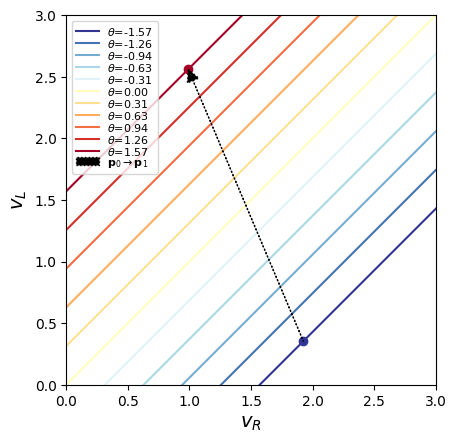

In [53]:
def plot_sols(L0=0.5, L1=1.4, plot_p = True):
    th_min, th_max = -pi/2, pi/2

    th_vals = linspace(th_min, th_max, 11)

    # Starting and ending points
    p0 = np.array([pi/2, 0]) + L0*np.array([1,1])/sqrt(2)
    p1 = np.array([0, pi/2]) + L1*np.array([1,1])/sqrt(2)

    col_fun = lambda th: cm.RdYlBu_r((th-th_min)/(th_max-th_min))

    v_R = linspace(0, 3*pi, 10)
    for th in th_vals:
        v_L = v_R + th
        plot(v_R, v_L, color=col_fun(th), label=f'$\\theta$={th:.2f}')

    if plot_p:
      # Plot some dots at the start and end points of our path through the solutions
      plot(*p0, 'o', color=col_fun(th_min))
      plot(*p1, 'o', color=col_fun(th_max))

      # Plot an arrow from p0 to p1 whose arrowhead is at p1
      arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True, zorder=10, linestyle=":", label="$\\mathbf{p}_0 \\to \\mathbf{p}_1$")

    # Axis cosmetics
    axis('square')
    xlim(0, 3); ylim(0, 3)
    xlabel('$v_R$', fontsize=14); ylabel('$v_L$', fontsize=14)
    legend(labelspacing=0, fontsize=8)
    return p0, p1

p0, p1 = plot_sols(plot_p=True)

It will be useful to plot eigenvectors on the same plot.

In [ ]:
def plot_eigs(p_cent, e1, e2, cols = [cm.cool(1.), cm.cool(0.)], **kwargs):
  arrow(p_cent[0], p_cent[1], e1[0], e1[1], head_width=0.1, head_length=0.1, fc=cols[0], ec=cols[0], length_includes_head=True, zorder=10, lw=2, label="$\\mathbf{q}_1$", **kwargs)
  arrow(p_cent[0], p_cent[1], e2[0], e2[1], head_width=0.1, head_length=0.1, fc=cols[1], ec=cols[1], length_includes_head=True, zorder=10, lw=2, label="$\\mathbf{q}_2$", **kwargs)
  legend(labelspacing=0, fontsize=8)


# Setting up the line attactor
We want to setup the linear system $$ \tau \dot{\mathbf{v}} = -\mathbf{v} + \mathbf{W v} + \mathbf{f}$$ to be a line attractor along the line from $\mathbf{p}_0$ to $\mathbf{p}_1$. To do so, we first specify the weight matrix, in terms of its eigenvectors and eigenvalues.

## The first eigenvector
 The first eigenvector has to point along $\mathbf{p}_1 - \mathbf{p}_0$, so we'll take it to be the corresponding unit vector. It has to have eigenvalue 1.

In [ ]:
q1 = (p1 - p0)/norm(p1-p0)
la1 = 1

# The second eigenvector
The second eigenvector can point in a different, but otherwise arbitrary direction, so we'll just set it to be some rotation of the first. Its eigenvalue should be much less than 1.

In [ ]:
rot = rand()*pi - pi/2
rot = pi/4
R = array([[cos(rot), -sin(rot)], [sin(rot), cos(rot)]]) # Rotation matrix
q2 = R @ e1
la2 = 0.2

Let's see what they look like.

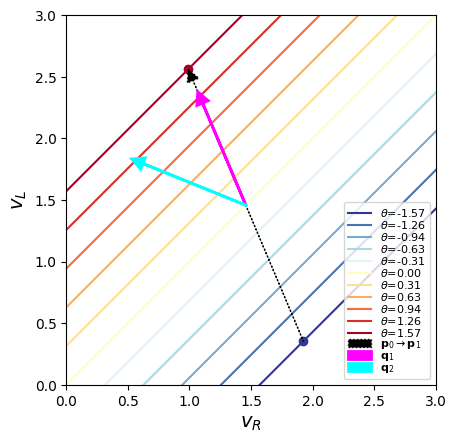

In [ ]:
p0, p1 = plot_sols()
p_cent = (p0 + p1)/2
plot_eigs(p_cent, q1, q2)

## Assembling the weight matrix
We can now assemble the weight matrix. If we first pack the eigenvectors into the matrix $$\mathbf Q = [\mathbf{q}_1, \mathbf{q}_2],$$ and the eigenvalues into the diagonal matrix $$\mathbf{D} = \begin{bmatrix} \lambda_1,& 0\\ 0, & \lambda_2 \end{bmatrix},$$ the eigenvector relationships can be expressed as $$\mathbf{W Q} = \mathbf{Q D}.$$ Therefore, $$\mathbf{W} = \mathbf{Q D Q^{-1}}.$$


In [ ]:
Q = np.column_stack((q1, q2))
D = np.diag([la1, la2])
iQ = inv(Q) # We'll need this to read out coordinates later as well.
W = Q @ D @ iQ

## Setting up the background drive
For the line attractor to work, we can't have any constant drive along the attractor dimension, otherwise it will get integrated to infinity. This means the background drive, in eigenvector coordinates, is $(0, \tilde f_2)$.

The second coordinate aligns our line attractor with the desired path in voltages space. Since these two lines are already pointing in the right direction, all we have to do is set the offset to that of a point that's already on the desired line, for example, that of $\mathbf{p}_0$. We use $\mathbf{Q}^{-1}$ to get the coordinates of a point.

In [ ]:
p0_ = iQ @ p0 # Get the coordinates of p0
f2_ = p0_[1] * (1 - la2)
f_ = np.array([0, f2_])
f = Q @ f_ # Now construct the drive from its coordinates.

## Making sure it works
We now have everything we need! So let's run the system from a few random initial conditions and make sure the dynamics converge to our desired line attractor.

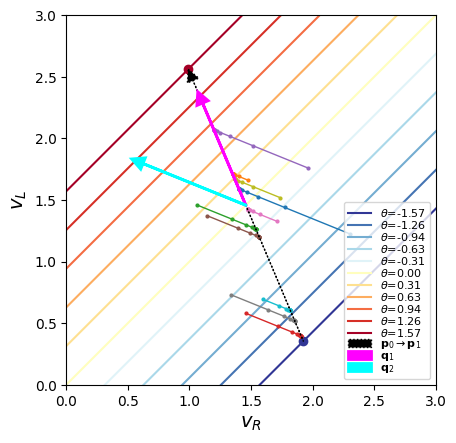

In [54]:
# Simulate dv/dt = -v + Wv + f
plot_sols()
plot_eigs(p_cent, q1, q2)

#
T = 10
dvdt = lambda v, t: -v + W @ v + f
p_cent = (p0 + p1)/2
random.seed(7)
for i in range(10):
    v_init = p_cent + 0.5*randn(2)
    v_sol = odeint(dvdt, v_init, linspace(0, T, 10))
    plot(v_sol[:,0], v_sol[:,1], 'o-', markersize=2, lw=1)

# Initialization

Let's try initializing so that we're on the $
\theta = 0$ line. This just means setting our coordinate along the attractor dimension to whatever of $\mathbf p_0$, then moving it half-way along towards $\mathbf p_1$. That is $$\tilde v_{01} = \tilde p_{01} + {1\over 2} \|\mathbf p_1 - \mathbf p_0\|.$$ We can set the other coordinate arbitrarily.

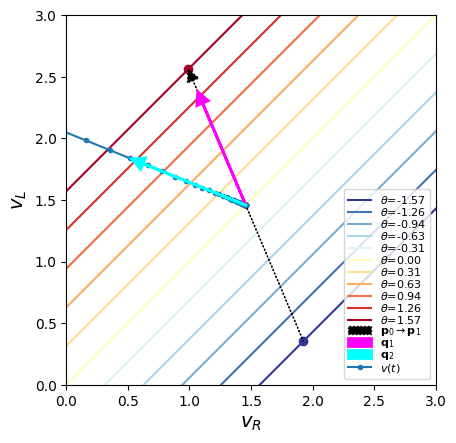

In [ ]:
p0, p1 = plot_sols()

plot_eigs(p_cent, e1, e2)

# Get the eigenvector coordinates of p0 and p1
p0_ = iQ @ p0
p1_ = iQ @ p1

v_init_1 = p0_[0] + 0.5 * norm(p1 - p0)
v_init_2 = p0_[1] + randn() * 1

v_init_ = np.array([v_init_1, v_init_2])
v_init = Q @ v_init_

v_sol = odeint(dvdt, v_init, linspace(0, T, 50))
plot(v_sol[:,0], v_sol[:,1], 'o-', markersize=3, label="$v(t)$")
legend(labelspacing=0,fontsize=8)

# Driving the attractor

To drive the attractor to different voltages (and therefore different eye directions) we will feed it with impulses along its attractor direction. Impulses are hard to directly incorporate into the ODE integration. Their effect is to instantaneously change the voltages by the amplitude of the impulse. So we will simulate their effect by initializing the ODE integration at whatever the last value was before the impulse, plus the instantaneous change due to the impulse.

In [ ]:
def get_angle(v):
  v_ = iQ @ v # Get eigenvector coordinates
  # Angle is our relative distance along the attractor
  theta = -pi/2 + (v_[0] - p0_[0])/(p1_[0] - p0_[0]) * pi
  return theta

targets = [pi/6,-pi/3]
# The previous value of the voltage is given by our location along the attractor
v_sol = odeint(dvdt, v_init, linspace(0, T, 50))
for theta_next in targets:
  theta_prev = get_angle(v_sol[-1])
  print(f"Previous angle: {theta_prev:.4g}")
  dtheta = theta_next - theta_prev
  dv_1 = norm(p1 - p0) * dtheta/pi
  dv   = Q[:,0] * dv_1
  v_post = v_sol[-1] + dv
  v_sol = odeint(dvdt, v_post, linspace(0, T, 50))
  theta_last = get_angle(v_sol[-1])
  print(f"Final angle: {theta_last:.2g} vs. Desired angle: {theta_next:.4g}")

Previous angle: -3.775e-15
Final angle: 0.52 vs. Desired angle: 0.5236
Previous angle: 0.5236
Final angle: -1 vs. Desired angle: -1.047
